# Модель лесного пожара

Лес состоит и пустой сетки $N \times N$. На протяжении каждого периода случайным образом
выбирается участок на сетке. Если участок пустой, то с вероятностью $p$ на нем вырастает
дерево, а с веростностью $1 - p$ не происходит ничего.

Если на участке растет дерево, то оно
с вероятностью $1 - p$ загорается и огонь распроcтраняется на все примыкающие участки с
деревьями.


In [130]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson, exp

In [145]:
class ForestField:
    def __init__(self, n=5, p = 0.6, smallSize = 50) -> None:
        self.n = n
        self.field = np.zeros((self.n, self.n), dtype=np.int32)
        self.p = p
        self.treesPreFire = []
        self.treesPostFire = []
        self.fireSize = []
        self.smallSize = smallSize
        self.smallArea = []
        self.dirt = 0
        self.tree = 1
        self.fire = -1
         
    def step(self, burnAll = True):
        cell = (np.random.randint(0, self.n), np.random.randint(0, self.n))
        rand_val = np.random.rand()
        #forest growth
        if self.field[cell[0], cell[1]] == self.dirt and rand_val < self.p:
                self.field[cell[0], cell[1]] = self.tree
        self.treesPreFire.append(self.countTrees())
        #lightning strike
        if self.field[cell[0], cell[1]] == self.tree and rand_val >= self.p:
            self.field[cell[0], cell[1]] = self.fire
        #fire spread
        self.fireSpread(burnAll)
        self.fireSize.append(self.countFire())
        #fire extinguish
        self.field[self.field == self.fire] = self.dirt
        self.treesPostFire.append(self.countTrees())
        self.smallArea.append(self.countSmallArea())
        
    def fireSpread(self, burnAll = False):
        dx = [-1, 0, 1, 0, -1, -1, 1, 1]
        dy = [0, 1, 0, -1, -1, 1, 1, -1]
        old_field = None
        while old_field is None or (old_field != self.field).any():
            old_field = self.field.copy()
            fire_indices = np.where(self.field == self.fire)
            fire_indices = list(zip(fire_indices[0], fire_indices[1]))
            for idx in fire_indices:
                i, j = idx
                for k in range(len(dx)):
                    if not ( 0 <= i + dx[k] < self.n and 0 <= j + dy[k] < self.n):
                        continue
                    if self.field[i + dx[k]][j + dy[k]] == self.dirt:
                        continue
                    self.field[i + dx[k]][j + dy[k]] = self.fire
            if not burnAll:
                return
        
    def countTrees(self):
        return np.sum(self.field[self.field == self.tree])
       
    def countFire(self):
        return -np.sum(self.field[self.field == self.fire])
    
    def countSmallArea(self):
        idx = int(self.n / 2 - self.smallSize / 2)
        area = self.field[idx:idx+self.smallSize, idx:idx+self.smallSize]
        return np.sum(area[area == self.tree])

Посмотрим на численность леса в течение продолжительного времени и исследуем распределение леса по его размеру

In [13]:
n = 100
p = 0.7
forest = ForestField(n=n, p=p)
time_steps = 30000

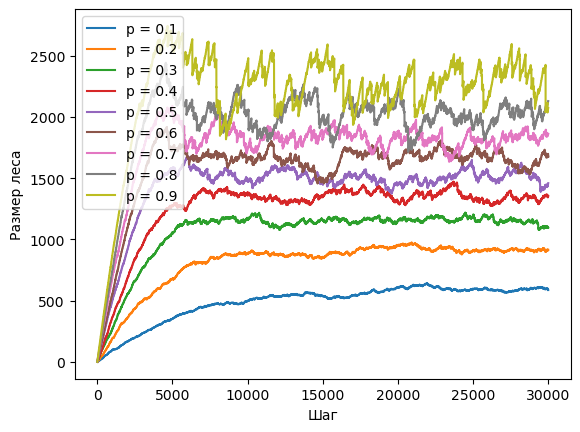

In [14]:
p_ax = np.arange(0.1, 1, 0.1)
for p in p_ax:
    forest = ForestField(n=n, p=p)
    for _ in range(time_steps):
        forest.step(burnAll=True)
    plt.plot(np.arange(len(forest.treesPreFire)), forest.treesPreFire, label=f'p = {np.round(p, 1)}')
plt.xlabel('Шаг')
plt.ylabel('Размер леса')
plt.legend()

Примерно до $T = 4000$ численность деревьев растёт линейно, затем численность выходит на насыщение и просходят колебания около среднего уровня. Эти скачки происходят из-за пожаров. Чем больше вероятность роста леса, тем более сильные колебания

In [15]:
p_vals = np.arange(0.01, 1, 0.09)
mean_vals = []
for p in p_vals:
    exp_forest = ForestField(n,p)
    for _ in range(time_steps):
        exp_forest.step(burnAll=True)
    mean_vals.append(np.mean(exp_forest.treesPostFire[int(time_steps / 2):]))

In [16]:
def calc_determination(data_x, data_y, coeffs):
    approx_y = np.polyval(coeffs, data_x)
    y_dev = np.sum((data_y - np.mean(data_y))**2)
    approx_dev = np.sum((approx_y - data_y)**2)
    return np.round(1 - approx_dev / y_dev, 2)

def approx_data(data_x, data_y, deg = 1):
    coeffs = np.polyfit(data_x, data_y, deg)
    determination = calc_determination(data_x, data_y, coeffs)
    return coeffs, determination

In [17]:
coeffs, r = approx_data(p_vals, mean_vals)
p_ax = np.linspace(0,1)
a_fit = np.polyval(coeffs, p_ax)

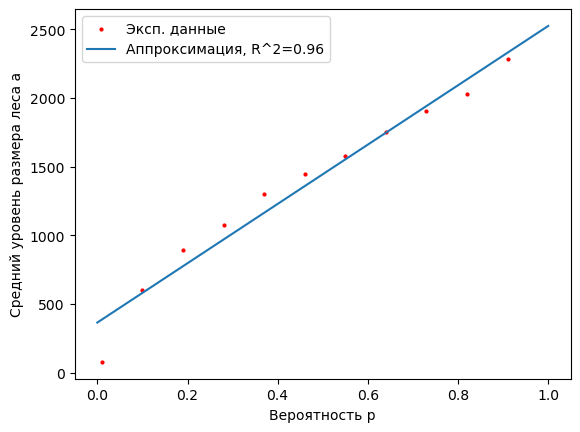

In [18]:
plt.scatter(p_vals, mean_vals, s=4, label='Эксп. данные', color='red')
plt.plot(p_ax, a_fit, label=f'Аппроксимация, R^2={r}')
plt.xlabel("Вероятность p")
plt.ylabel("Средний уровень размера леса a")
plt.legend()

В такой постановке задачи оценки размеров кластеров проще оценить размер кластера пожара, исследуем эту зависимость

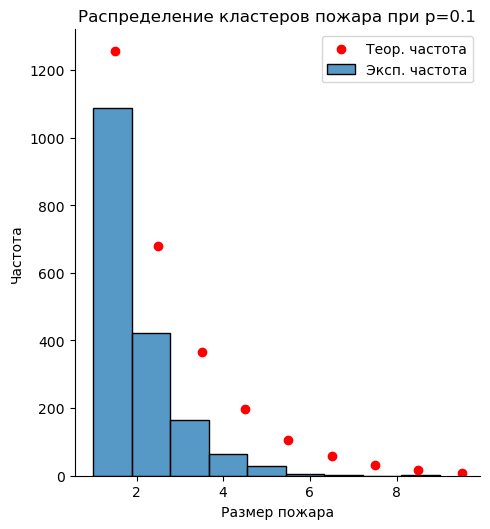

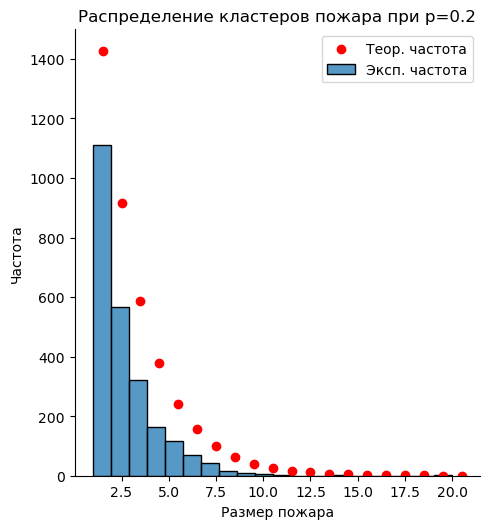

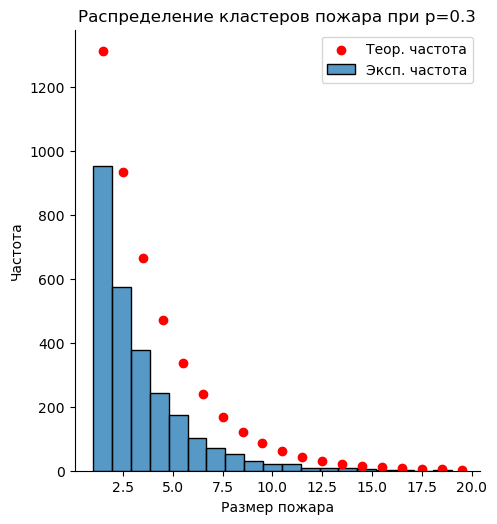

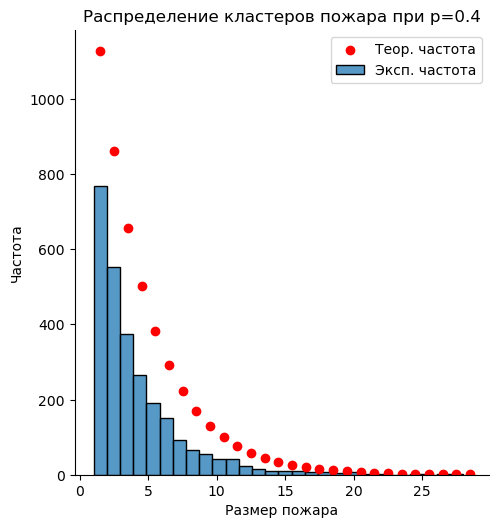

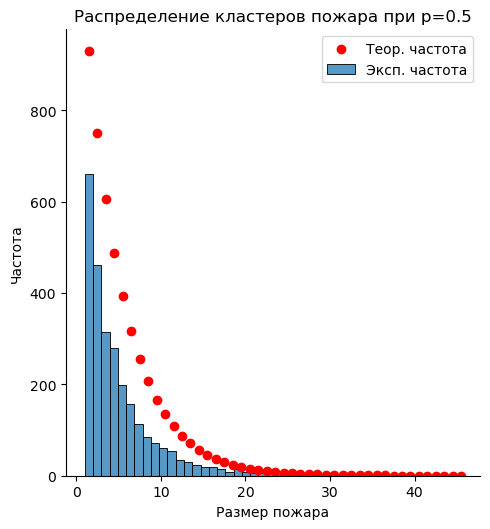

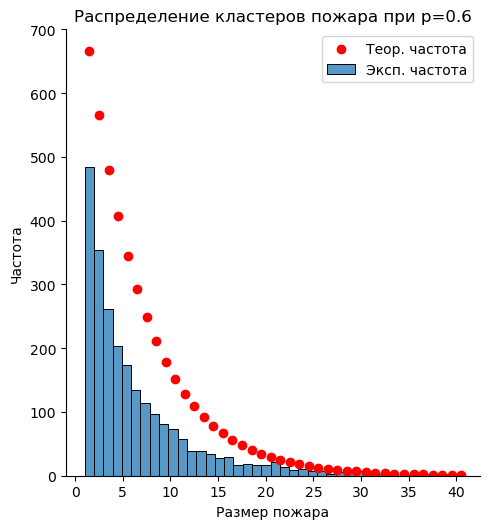

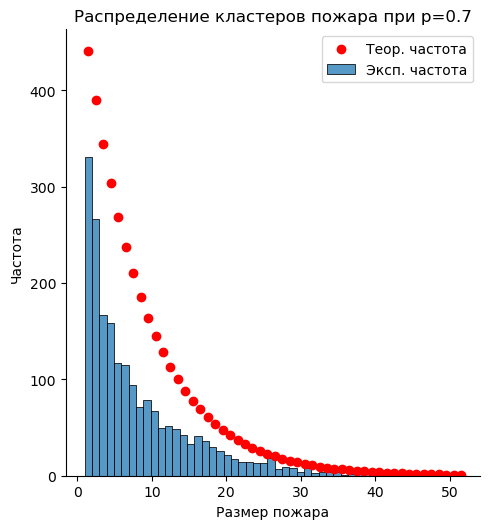

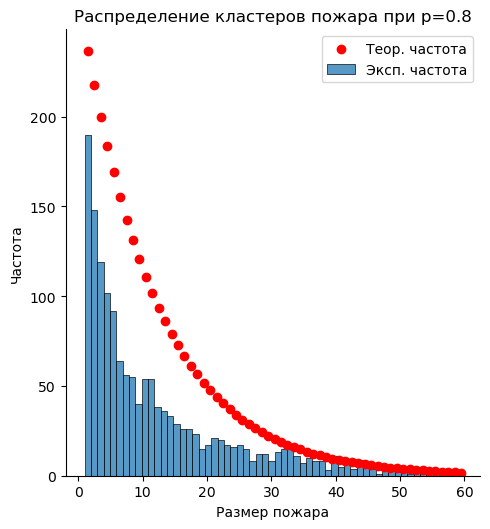

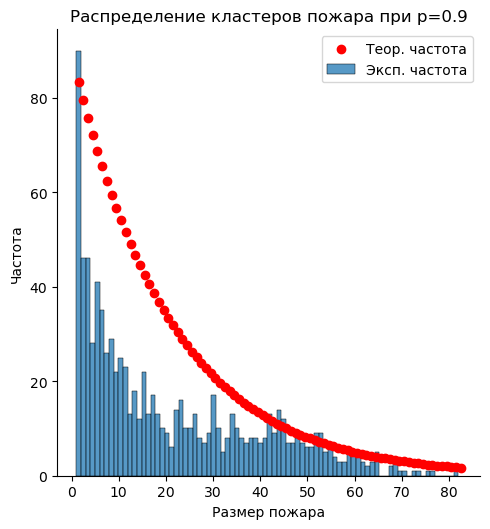

In [201]:
p_vals = np.arange(0.1, 1, 0.1)
lambda_vals_exp = []
for p in p_vals:
    forest = ForestField(n=10, p=p, smallSize=30)
    for _ in range(30000):
        forest.step()
    fire = np.array(forest.fireSize)
    fire = fire[fire != 0]
    int_vals = np.arange(np.min(fire), np.max(fire) + 1)
    lambda_exp = 1/np.mean(fire)
    lambda_vals_exp.append(lambda_exp)
    exp_prob = lambda x, alpha: np.exp(- alpha * (x - 1)) - np.exp(- alpha * (x + 1))
    exp_prob_vals = exp_prob(int_vals, lambda_exp) * len(fire)
    bin_num = int(np.max(fire) - np.min(fire) + 1)
    ax = sns.displot(fire, label = "Эксп. частота",bins=bin_num)
    ax.set(xlabel="Размер пожара", ylabel="Частота", title=f"Распределение кластеров пожара при p={np.round(p, 2)}")
    plt.scatter(int_vals + 0.5, exp_prob_vals, color='red', label='Теор. частота')
    plt.legend()

Распределение похоже на экспоненциальное. Важно также отметить, что в теоретическую модель подставляются значения из предположения, что распределение непрерывное и размер кластера пожара может принимать любое неотрицательное значение, а не только целые. Такая модель получается при условии, что за один такт пожар распространяется на соседей и далее. Посмотрим, как будет выглядеть распределение, если загораются только соседние участки от места удара молнии, а затем они затухают

Исследуем зависимость параметра $\lambda$ от $p$

In [202]:
def calc_determination(data_x, data_y, coeffs):
    approx_y = np.polyval(coeffs, data_x)
    y_dev = np.sum((data_y - np.mean(data_y))**2)
    approx_dev = np.sum((approx_y - data_y)**2)
    return np.round(1 - approx_dev / y_dev, 2)

def approx_data(data_x, data_y, deg = 1):
    coeffs = np.polyfit(data_x, data_y, deg)
    determination = calc_determination(data_x, data_y, coeffs)
    return coeffs, determination

In [203]:
p_ax = np.linspace(0, 1)
coeffs, r = approx_data(p_vals, np.log(lambda_vals_exp), deg=1)
fit_l = np.polyval(coeffs, p_ax)
fit_l = np.exp(fit_l)

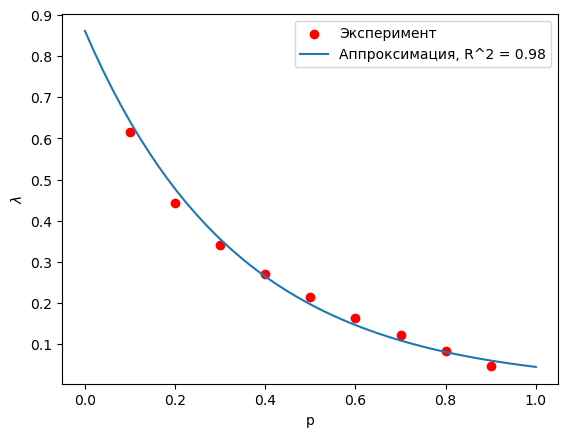

In [204]:
plt.scatter(p_vals, lambda_vals_exp, color='red', label='Эксперимент')
plt.plot(p_ax, fit_l, label=f'Аппроксимация, R^2 = {r}')
plt.xlabel("p")
plt.ylabel(r"$\lambda$")
plt.legend()

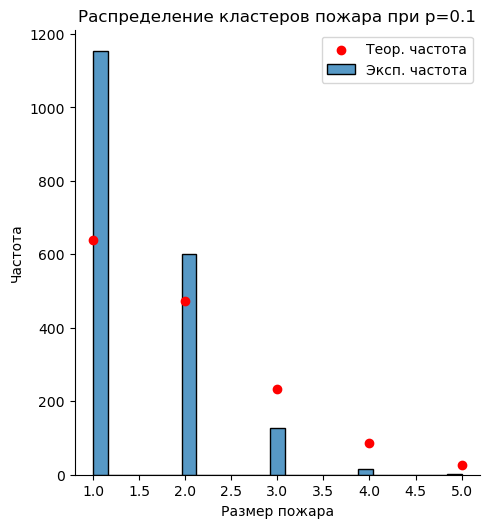

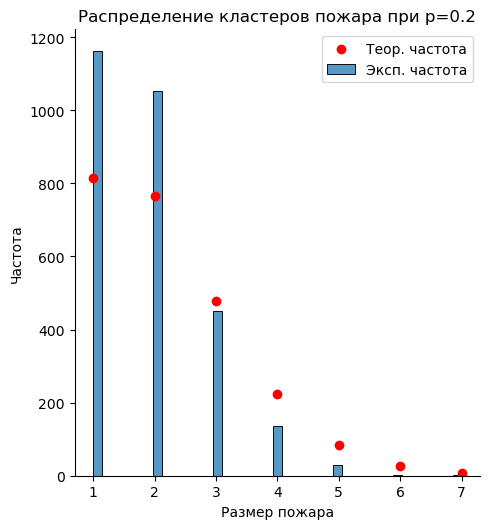

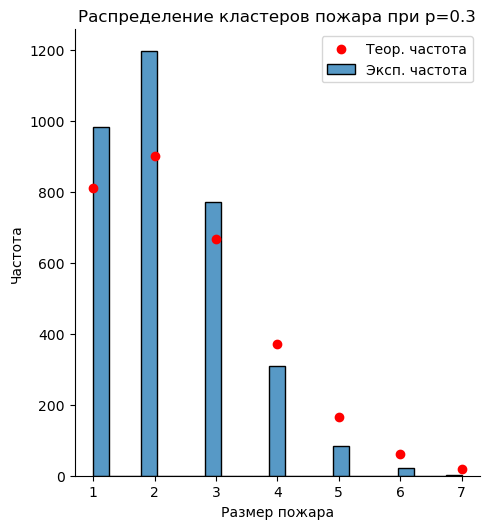

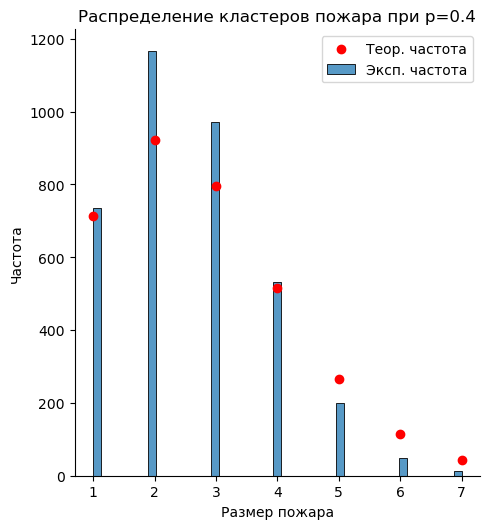

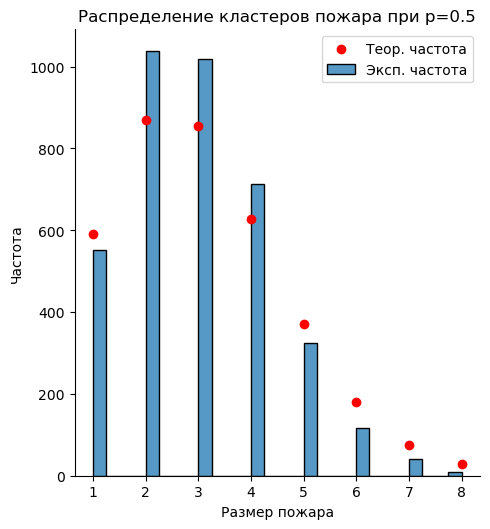

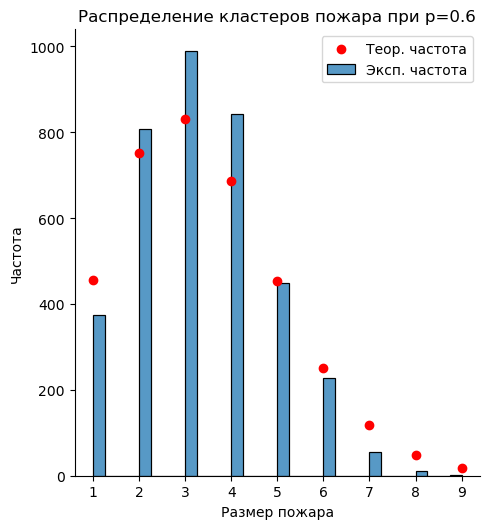

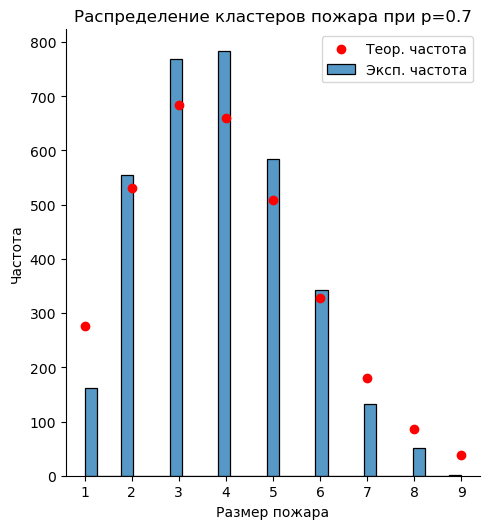

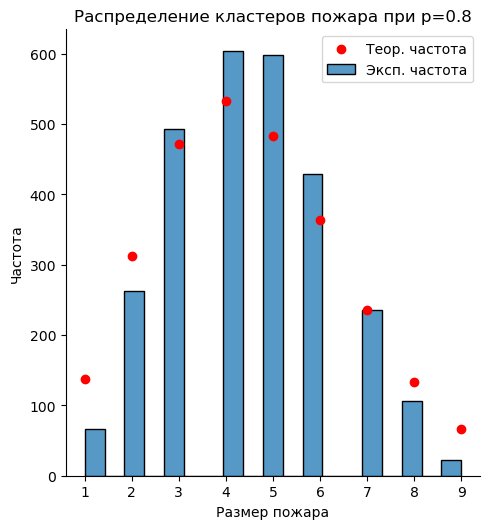

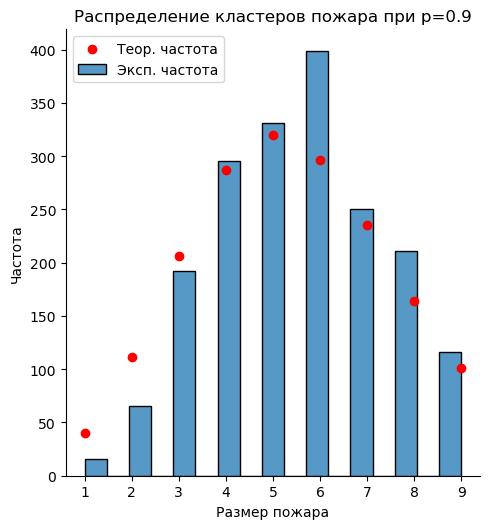

In [205]:
p_vals = np.arange(0.1, 1, 0.1)
lambda_vals_pois = []
for p in p_vals:
    forest = ForestField(n=10, p=p, smallSize=30)
    for _ in range(30000):
        forest.step(burnAll=False)
    fire = np.array(forest.fireSize)
    fire = fire[fire != 0]
    int_vals = np.arange(np.min(fire), np.max(fire) + 1)
    lambda_exp = np.mean(fire)
    lambda_vals_pois.append(lambda_exp)
    pois_vals = poisson.pmf(int_vals, lambda_exp) * len(fire)
    ax = sns.displot(fire, label = "Эксп. частота")
    ax.set(xlabel="Размер пожара", ylabel="Частота", title=f"Распределение кластеров пожара при p={np.round(p, 2)}")
    plt.scatter(int_vals, pois_vals, color='red', label='Теор. частота')
    plt.legend()

In [206]:
coeffs_p, r_p = approx_data(p_vals, np.log(lambda_vals_pois), deg=1)
fit_l_p = np.polyval(coeffs_p, p_ax)
fit_l_p = np.exp(fit_l_p)

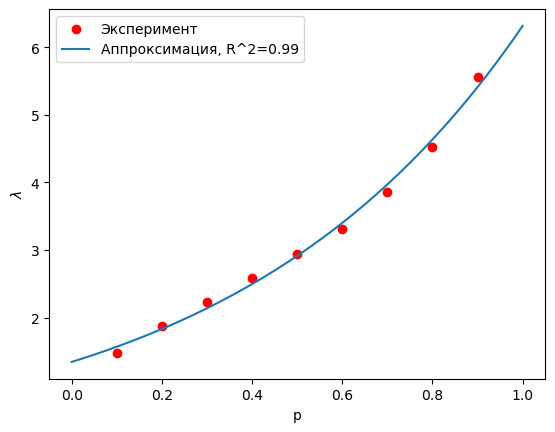

In [207]:
plt.scatter(p_vals, lambda_vals_pois, color='red', label='Эксперимент')
plt.plot(p_ax, fit_l_p, label=f'Аппроксимация, R^2={r_p}')
plt.xlabel("p")
plt.ylabel(r"$\lambda$")
plt.legend()